# Executive Summary

This report describes the approach taken to build a gym subscription prediction model based on the user data provided as an input. It consist of descriptions, as well as the code written in Python language used to process data, build a model, and obtain final results. First section of this report serves to access data, get familiar with it, clean it, and transform it for the model to read it. Second section explains which model was selected and how it was build, compiled, and fit. Next section presents model quality assessment approach. Then, it is shown how the test file was scored with the prepared model. Last two sections describe findings encountered during the process and limitations of selected approach.

# Input Data and Transformations

In this section the process of analysis of the provided data is described. For this task I am going to store data in a format of so-called dataframes (DataFrame classes) from Pandas library wirtten for Python language:

In [30]:
import pandas as pd

### Access data

The data provided for this task has been uploaded in order to automatize this report. To access data I am going to clone the files that I stored in the git repository:

In [ ]:
!git clone https://github.com/pkarczma/gym-subscription-predictor.git

Next, one needs to read it. I am going to start with the data used for training. The data consist of CSV and JSON files, which are going to be read into two dataframes:

In [32]:
path = 'gym-subscription-predictor/'
df_csv = pd.read_csv(path+'train.csv')
df_json = pd.read_json(path+'train.json', orient='split').set_index('id')

### Merge data

The data for each used is split into two files: structured CSV file and unstructured JSON file. The data read from JSON file is unstructured. What we would like to achieve is one dataframe that consist of rows containing all the information about each user. To do that the data read from JSON file needs some conversion in order to extract necessary data nested inside. A new dataframe containing a list of group names for each user will be extracted. The information about the date of joining the group is skipped as this seem redundant for this task.

In [33]:
df_groups = pd.DataFrame(columns=['groups'])
for i in df_json.to_dict()['groups'].items():
  groups = ''
  for j in i[1]['data']:
    if len(groups) > 0:
      groups += '|'
    groups += j['group_name']
  df_groups = df_groups.append({'groups': groups}, ignore_index=True)

Now it is possible to merge two dataframes into one dataset containing all information about each user:

In [34]:
df = pd.concat([df_csv, df_groups], axis=1)

### Analyse and clear data

This section focuses on getting familiar with the data. One can have a look at some information about the dataframe and its columns, as well as look at the first few rows of the dataframe:

In [35]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   4000 non-null   int64  
 1   target                    4000 non-null   int64  
 2   name                      3982 non-null   object 
 3   sex                       3616 non-null   object 
 4   dob                       3606 non-null   object 
 5   location                  4000 non-null   object 
 6   location_population       4000 non-null   int64  
 7   location_from             4000 non-null   object 
 8   location_from_population  4000 non-null   int64  
 9   occupation                4000 non-null   object 
 10  hobbies                   3320 non-null   object 
 11  daily_commute             3595 non-null   float64
 12  friends_number            4000 non-null   int64  
 13  relationship_status       3607 non-null   object 
 14  educatio

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,hobbies,daily_commute,friends_number,relationship_status,education,credit_card_type,groups
0,0,1,Halina,NaN,1982-08-07,Piastów,22732,Piastów,22732,Teaching professionals,Fitness,46.0,196,Single,NaN,Visa,Let's excercise together and lose a few kilo q...
1,1,0,Eustachy,male,1971-10-28,Sokółka,18331,Sokółka,18331,General and keyboard clerks,"LARPing,Foreign language learning,Netball",55.0,243,Single,NaN,NaN,Tom Cruise group|Babysitters (Sokółka)|Work ab...
2,2,1,Egon,NaN,2000-07-05,Łaskarzew,4879,Łaskarzew,4879,Protective services workers,"Bodybuilding,Kabaddi",90.0,191,In relationship,3.0,NaN,Polish wildlife - best places|Politics and pol...
3,3,0,Eulalia,female,1992-06-10,Bydgoszcz,352313,Bydgoszcz,352313,Customer services clerks,Badminton,88.0,164,In relationship,3.0,Visa,The Aspiring Writer|Nutrition & food advices|G...
4,4,0,Hilary,NaN,1975-01-09,Osieczna,2322,Poznań,538633,Refuse workers and other elementary workers,"Fitness,Embroidery,Lacemaking",40.0,119,Married with kids,5.0,NaN,The ultimate house and electro group|Pirates o...


This overview enables extraction of many useful information. There are 4000 users and 16 columns describing each user. There are some columns with empty cells, but it will be dealt with later. At this point it would be useful to evaluate which part of the data isn't necessary for the model. It is going to be assumed that the following columns are not indicating an initial interest in gym subscription:
* name
* location_population
* location_from_population
* daily_commute
* credit_card_type

As a result I am going to drop them from the dataframe:

In [36]:
df = df.drop(columns=['name', 'location_population', 'location_from_population', 'daily_commute', 'credit_card_type'])

Afterwards, one can focus on the missing values that are still in the remaining data. It is useful to count the number of missing values in each of the remaining columns:

In [37]:
df.isnull().sum(axis = 0)

user_id                  0
target                   0
sex                    384
dob                    394
location                 0
location_from            0
occupation               0
hobbies                680
friends_number           0
relationship_status    393
education              408
groups                   0
dtype: int64

There are still some missing values in data in several columns. I am going to use a different approach depending on the column with the missing values. The following procedure will be applied:
* 'user_id' / 'target' / 'location' / 'location_from' / 'occupation' / 'friends_number': no missing values, columns are useful, nothing changes
* 'education': fill missing values with a median of a column
* 'hobbies': I assume that empty value means that a user has no hobbies, so I will fill missing values with empty string

For the remaining data with missing values it is problematic to deduce how replace it. One can also notice that the fraction of missing values to all values isn't too large - it is around 10% for each of the remaining columns with missing values. Consequently, the rows with at least one missing calue will be dropped from the dataset.



In [38]:
df['hobbies'] = df['hobbies'].fillna('')
df['education'] = df['education'].fillna(df['education'].median())
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2945 entries, 1 to 3999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              2945 non-null   int64  
 1   target               2945 non-null   int64  
 2   sex                  2945 non-null   object 
 3   dob                  2945 non-null   object 
 4   location             2945 non-null   object 
 5   location_from        2945 non-null   object 
 6   occupation           2945 non-null   object 
 7   hobbies              2945 non-null   object 
 8   friends_number       2945 non-null   int64  
 9   relationship_status  2945 non-null   object 
 10  education            2945 non-null   float64
 11  groups               2945 non-null   object 
dtypes: float64(1), int64(3), object(8)
memory usage: 299.1+ KB


As a result, around 25% of all rows were removed and there are 2945 users left. I assume that this is a sufficient number of entries for the model. Now the data is clean and ready for the next step.

### Transform data

In order to prepare data for the model a convertion to the proper format is needed. The following code will convert non-numeric data to categories so that is it easier for the model to read it:

In [39]:
df['sex'] = df['sex'].astype('category').cat.codes
df['location'] = df['location'].astype('category').cat.codes
df['location_from'] = df['location_from'].astype('category').cat.codes
df['occupation'] = df['occupation'].astype('category').cat.codes
df['relationship_status'] = df['relationship_status'].astype('category').cat.codes

For the date of birth, I assume there is no need to keep the exact date - having just a year of birth should be enough for the model. I will drop the day and month information from 'dob' column:

In [40]:
df['dob'] = pd.DatetimeIndex(df['dob']).year

For the 'hobbies' column the best way is to extract dummies for each row and split it into columns with values of 0 or 1 indicating interest (or lack of interest) in a particular hobby. An additional 'hobby_' prefix will indicate that this column represents a hobby, but also to make sure that none of the column names are overlapping with the rest.

In [41]:
df = pd.concat([df.drop('hobbies', axis=1), df['hobbies'].str.get_dummies(sep=',').add_prefix('hobby_')], axis=1)

I am going to apply a similar procedure to the 'groups' column:

In [42]:
df = pd.concat([df.drop('groups', axis=1), df['groups'].str.get_dummies(sep='|').add_prefix('group_')], axis=1)

At this point the data contains only numbers, there are no missing values, and it is prepared for the next step.

In [43]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2945 entries, 1 to 3999
Columns: 3521 entries, user_id to group_muscle, strength  and vascularity - What every bodybuilder should know
dtypes: float64(1), int16(2), int64(3515), int8(3)
memory usage: 79.0 MB


,user_id,target,sex,dob,location,location_from,occupation,friends_number,relationship_status,education,hobby_3D printing,hobby_Acting,hobby_Air sports,hobby_Amateur radio,hobby_Archery,hobby_Astronomy,hobby_BASE jumping,hobby_Backpacking,hobby_Badminton,hobby_Baseball,hobby_Basketball,hobby_Beekeeping,hobby_Bird watching,hobby_Blacksmithing,hobby_Board games,hobby_Board sports,hobby_Bodybuilding,hobby_Book restoration,hobby_Brazilian jiu-jitsu,hobby_Cabaret,hobby_Calligraphy,hobby_Candle making,hobby_Cardio,hobby_Coffee roasting,hobby_Coloring,hobby_Community,hobby_Computer programming,hobby_Cooking,hobby_Cosplaying,hobby_Creative writing,...,group_Work abroad - join to find well paid work and enjoy the experience (Sopot),group_Work abroad - join to find well paid work and enjoy the experience (Sosnowiec),group_Work abroad - join to find well paid work and enjoy the experience (Swarzędz),group_Work abroad - join to find well paid work and enjoy the experience (Szczecin),group_Work abroad - join to find well paid work and enjoy the experience (Słubice),group_Work abroad - join to find well paid work and enjoy the experience (Słupsk),group_Work abroad - join to find well paid work and enjoy the experience (Tarnów),group_Work abroad - join to find well paid work and enjoy the experience (Tczew),group_Work abroad - join to find well paid work and enjoy the experience (Terespol),group_Work abroad - join to find well paid work and enjoy the experience (Tomaszów Mazowiecki),group_Work abroad - join to find well paid work and enjoy the experience (Toruń),group_Work abroad - join to find well paid work and enjoy the experience (Tuchola),group_Work abroad - join to find well paid work and enjoy the experience (Tychy),group_Work abroad - join to find well paid work and enjoy the experience (Warszawa),group_Work abroad - join to find well paid work and enjoy the experience (Warta),group_Work abroad - join to find well paid work and enjoy the experience (Wasilków),group_Work abroad - join to find well paid work and enjoy the experience (Wolbrom),group_Work abroad - join to find well paid work and enjoy the experience (Wrocław),group_Work abroad - join to find well paid work and enjoy the experience (Włocławek),group_Work abroad - join to find well paid work and enjoy the experience (Zabrze),group_Work abroad - join to find well paid work and enjoy the experience (Zator),group_Work abroad - join to find well paid work and enjoy the experience (Zduńska Wola),group_Work abroad - join to find well paid work and enjoy the experience (Zielona Góra),group_Work abroad - join to find well paid work and enjoy the experience (Ząbki),group_Work abroad - join to find well paid work and enjoy the experience (Łomża),group_Work abroad - join to find well paid work and enjoy the experience (Łódź),group_Work abroad - join to find well paid work and enjoy the experience (Śrem),group_Work abroad - join to find well paid work and enjoy the experience (Świdnik),group_Work abroad - join to find well paid work and enjoy the experience (Świętochłowice),group_Work abroad - join to find well paid work and enjoy the experience (Żagań),group_Work abroad - join to find well paid work and enjoy the experience (Żary),group_Work abroad - join to find well paid work and enjoy the experience (Żyrardów),group_World Weightlifting Championships,"group_Xbox , Playstation, Wii - console fans","group_Young, fit and healthy - active livestyle = healthy lifestyle.",group_ZTM Warsaw,group_alternative medicine - Hypnosis and bioenergotheraphy,group_ham cooker - recipes,group_instrumental music - the unheard and undiscovered,"group_muscle, strength and vascularity - What every bodybuilder should know"
1,1,0,1,1971,400,415,15,243,4,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,1992,46,35,10,164,1,3.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,

# Model Selection and Training

In this section I am going to build a model that will be used for predictions. For this task I am going to use Keras interface from the TensorFlow library, as well as some other libraries necessary for data validation and plotting.

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Split data

For the model training and testing the dataset will be split into two subsets:
* 80% of the data will be used for training
* 20% od the remaining data will be used for testing

In [45]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

I am going to separate labels from features:

In [46]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('target')
test_labels = test_features.pop('target')

### Build model

Now it is time to build a model. The selected model will be a regression-based neural network consisting of several input, hidden, and output layers. It will use existing data prepared in the previous section as an input in order to create predictions of the desired variable.

This model prefers to have the input data normalized in a specific way. Thus, one needs to create a normalization layer that is adapted to the dataset:

In [47]:
normalizer = layers.experimental.preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

Afterwards, one can build a fully-connected model consisting of a sequential stack of layers, where first layer is a normalization layer, then there are hidden layers using a rectified linear unit as an activation function, while the last output layer is using a sigmoid function in order to ensure that the network output is between 0 and 1.

In [48]:
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(3520, input_dim=3520, activation='relu'),
    layers.Dense(440, activation='relu'),
    layers.Dense(55, activation='relu'),
    layers.Dense(11, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3520)              7041      
_________________________________________________________________
dense_5 (Dense)              (None, 3520)              12393920  
_________________________________________________________________
dense_6 (Dense)              (None, 440)               1549240   
_________________________________________________________________
dense_7 (Dense)              (None, 55)                24255     
_________________________________________________________________
dense_8 (Dense)              (None, 11)                616       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 12        
Total params: 13,975,084
Trainable params: 13,968,043
Non-trainable params: 7,041
______________________________________

### Compile and fit model



Next step is to compile the model. It is necessary to specify the loss function to use for weights evaluation. As this is a binary classification problem the model is going to use 'binary_crossentropy' as a loss function. The model will be classified using the collected accuracy value. It is also going to use Adam optimization algorithm.

In [49]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy'])

Then, one can fit the model providing different settings that can be adjusted for the model efficacy.



In [50]:
history = model.fit(
    # Data to be used for training
    train_features, train_labels,
    # Number of epochs
    epochs=5,
    # Suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

After fitting one can have a look at the last few epochs of the training of the model in order to see if everything works well.

In [51]:
# Show history in the last few epochs
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.465442,0.772293,0.459809,0.773305,0
1,0.253374,0.908174,0.484006,0.773305,1
2,0.156466,0.983015,0.529981,0.790254,2
3,0.138948,0.991507,0.552562,0.690678,3
4,0.132086,0.993631,0.564924,0.673729,4


# Model Quality Assessment

In order to assess the quality of the model I am going to use the fraction of the dataset that hasn't been provided to the model yet. One can extract a list of probabilities for each user in the test sample.

In [52]:
test_predictions = model.predict(test_features)

Now it is possible to extract the fraction of correct prediction by comparing it to the true labels:

In [53]:
correct = sum(i == j for i, j in zip(np.around(test_predictions), test_labels))[0]
print(correct / len(test_labels))

0.8455008488964346


One can see that over 85% of predictions are correct. Even better way to look at the results is to create a confuction matrix showing the fraction of correct and incorrect predictions in each class (in this case it will be '0' and '1' as this is a binary classification).

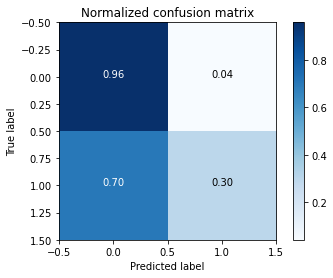

In [54]:
cm = confusion_matrix(test_labels, np.around(test_predictions))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{0:0.2f}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

One can see that almost all labels marked as '0' are correctly identified. For labels marked as '1' the model doesn't work that well and predicts correctly only around 30% of all cases. This means that the model predicts very well who is not interested in gym subscription, but identifies only a fraction of users interested in subscription.

# Scoring Test File

In this section the model will be used to produce target variable on the data stored in test.csv and test.json files. The test files will be read and transformed in a similar way as before. I will also remove rows that are missing some data and only for the remaining rows the model will be used for predictions.

In [55]:
df_model = df.copy()
df_csv = pd.read_csv(path+'test.csv')
df_json = pd.read_json(path+'test.json', orient='split').set_index('id')
df_groups = pd.DataFrame(columns=['groups'])
for i in df_json.to_dict()['groups'].items():
  groups = ''
  for j in i[1]['data']:
    if len(groups) > 0:
      groups += '|'
    groups += j['group_name']
  df_groups = df_groups.append({'groups': groups}, ignore_index=True)
df_groups.head()
df = pd.concat([df_csv, df_groups], axis=1)
df = df.drop(columns=['target', 'name', 'location_population', 'location_from_population', 'daily_commute', 'credit_card_type'])
df['hobbies'] = df['hobbies'].fillna('')
df['education'] = df['education'].fillna(df['education'].median())
df = df.dropna()
df['sex'] = df['sex'].astype('category').cat.codes
df['location'] = df['location'].astype('category').cat.codes
df['location_from'] = df['location_from'].astype('category').cat.codes
df['occupation'] = df['occupation'].astype('category').cat.codes
df['relationship_status'] = df['relationship_status'].astype('category').cat.codes
df['dob'] = pd.DatetimeIndex(df['dob']).year
df = pd.concat([df.drop('hobbies', axis=1), df['hobbies'].str.get_dummies(sep=',').add_prefix('hobby_')], axis=1)
df = pd.concat([df.drop('groups', axis=1), df['groups'].str.get_dummies(sep='|').add_prefix('group_')], axis=1)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 0 to 1999
Columns: 2176 entries, user_id to group_muscle, strength  and vascularity - What every bodybuilder should know
dtypes: float64(1), int16(2), int64(2170), int8(3)
memory usage: 24.1 MB


,user_id,sex,dob,location,location_from,occupation,friends_number,relationship_status,education,hobby_3D printing,hobby_Acting,hobby_Air sports,hobby_Amateur radio,hobby_Archery,hobby_Astronomy,hobby_BASE jumping,hobby_Backpacking,hobby_Badminton,hobby_Baseball,hobby_Basketball,hobby_Beekeeping,hobby_Bird watching,hobby_Blacksmithing,hobby_Board games,hobby_Board sports,hobby_Bodybuilding,hobby_Book restoration,hobby_Brazilian jiu-jitsu,hobby_Cabaret,hobby_Calligraphy,hobby_Candle making,hobby_Cardio,hobby_Coffee roasting,hobby_Coloring,hobby_Community,hobby_Computer programming,hobby_Cooking,hobby_Cosplaying,hobby_Creative writing,hobby_Crocheting,...,group_Work abroad - join to find well paid work and enjoy the experience (Poznań),group_Work abroad - join to find well paid work and enjoy the experience (Przasnysz),group_Work abroad - join to find well paid work and enjoy the experience (Pułtusk),group_Work abroad - join to find well paid work and enjoy the experience (Płock),group_Work abroad - join to find well paid work and enjoy the experience (Racibórz),group_Work abroad - join to find well paid work and enjoy the experience (Rybnik),group_Work abroad - join to find well paid work and enjoy the experience (Rychwał),group_Work abroad - join to find well paid work and enjoy the experience (Siedlce),group_Work abroad - join to find well paid work and enjoy the experience (Staszów),group_Work abroad - join to find well paid work and enjoy the experience (Sulejówek),group_Work abroad - join to find well paid work and enjoy the experience (Suwałki),group_Work abroad - join to find well paid work and enjoy the experience (Swarzędz),group_Work abroad - join to find well paid work and enjoy the experience (Szczecin),group_Work abroad - join to find well paid work and enjoy the experience (Tczew),group_Work abroad - join to find well paid work and enjoy the experience (Tułowice),group_Work abroad - join to find well paid work and enjoy the experience (Tychy),group_Work abroad - join to find well paid work and enjoy the experience (Warszawa),group_Work abroad - join to find well paid work and enjoy the experience (Wieluń),group_Work abroad - join to find well paid work and enjoy the experience (Więcbork),group_Work abroad - join to find well paid work and enjoy the experience (Wolsztyn),group_Work abroad - join to find well paid work and enjoy the experience (Wrocław),group_Work abroad - join to find well paid work and enjoy the experience (Wronki),group_Work abroad - join to find well paid work and enjoy the experience (Zabrze),group_Work abroad - join to find well paid work and enjoy the experience (Zakopane),group_Work abroad - join to find well paid work and enjoy the experience (Zduny),group_Work abroad - join to find well paid work and enjoy the experience (Zielona Góra),group_Work abroad - join to find well paid work and enjoy the experience (Ząbki),group_Work abroad - join to find well paid work and enjoy the experience (Łomża),group_Work abroad - join to find well paid work and enjoy the experience (Łódź),group_Work abroad - join to find well paid work and enjoy the experience (Świątniki Górne),group_Work abroad - join to find well paid work and enjoy the experience (Świętochłowice),group_Work abroad - join to find well paid work and enjoy the experience (Żory),group_World Weightlifting Championships,"group_Xbox , Playstation, Wii - console fans","group_Young, fit and healthy - active livestyle = healthy lifestyle.",group_ZTM Warsaw,group_alternative medicine - Hypnosis and bioenergotheraphy,group_ham cooker - recipes,group_instrumental music - the unheard and undiscovered,"group_muscle, strength and vascularity - What every bodybuilder should know"
0,0,1,1973,152,337,29,146,4,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,1,1991,301,251,14,209,3,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,

This dataframe has a different number of columns than before due to the different set of hobbies and groups that users belong to. It is needed to add columns that are missing from this dataframe and remove additional columns that didn't exist previously in order to have exactly the same set of columns as in the dataframe used for the model. New columns will be filled with '0'. Additional column will be dropped because the model doesn't know what to do with hobbies or groups that didn't exist in the fitting data.

In [56]:
missing_col = df_model.columns.difference(df.columns)
for col in missing_col:
  df[col] = 0
additional_col = df.columns.difference(df_model.columns)
df.drop(labels=additional_col.tolist(), axis=1, inplace=True)
df.drop(labels='target', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 0 to 1999
Columns: 3520 entries, user_id to group_Work abroad - join to find well paid work and enjoy the experience (Żyrardów)
dtypes: float64(1), int16(2), int64(3514), int8(3)
memory usage: 39.0 MB


Now the model can be used to predict target value for the test dataset. As a result one gets a list of probabilities for each user included in the dataset:

In [57]:
test_features = df.copy()
test_predictions = model.predict(test_features)
print(test_predictions)

[[0.00345144]
 [0.        ]
 [0.        ]
 ...
 [0.5430761 ]
 [0.5430761 ]
 [0.5430761 ]]


Finally, it is possible to prepare a scored test file. For the rows that were skipped in the prediction phase due to missing information I am going to assume the target variable is '0'. For the rest of the users I will use predicted probability and set a target value by rounding probability to the nearest integer value. Then, the output file will be saved as a CSV in a desired format consisting of 3 columns: 'user_id', 'probability_of_one', and 'target'.

In [58]:
df_score = pd.DataFrame(columns=['user_id', 'probability_of_one', 'target'])
user_pred = 0
for user in range(df_csv.shape[0]):
  if user in df['user_id']:
    df_score =df_score.append({'user_id': user, 'probability_of_one': test_predictions[user_pred][0], 'target': np.around(test_predictions[user_pred][0])}, ignore_index=True)
    user_pred += 1
  else:
    df_score =df_score.append({'user_id': user, 'probability_of_one': 0., 'target': 0.}, ignore_index=True)
df_score = df_score.astype({'user_id': int, 'target': int})
df_score.head()
df_score.to_csv('test.csv', index=False)

# Findings

During the process of analysis of the data it was discovered that some information is missing. It is not always clear what to do with missing data, so several assumptions were made. 

Moreover, it would require more detailed analysis of the input data to discover what part of data is useful for the model and which part could be removed. One of the possible solutions would be to use heatmaps to find correlations between data. A detailed investigation of the data would be necessary to determine what should be used as an input for the model.

It was also discovered that the model works well predicting a lack of interest in gym subscription, but it works much worse when trying to find people interested in the subscription. This is most probably connected with the fact that the model can still be tuned in a better way. A further investigation of a possible layer settings of the model should also be tested to find a better solution.

# Limitations of the Approach

This approach has various limitations. First of all, it is assumed that the model will be used to predict interest for users with similar hobbies and belonging to similar groups. In practice this may not be the case.

Furthermore, the approach of extracting hobbies and groups into separate columns generated more than three thousand columns in the dataset. This value might get even bigger when using a different dataset as an input file, because one can produce even more columns and run out of available memory at some point.

The model was also built and tested without any information from the JSON file at all in the first attempt - this means that no information about groups was included. This solution reduced the number of columns significantly and the model had a higher efficacy of predicting users interested in gym subscription. On the other hand, it had lower efficacy of predicting users not interested in the subscription and a slightly lower efficiency overall. It depends on the approach, but one can focus on maximizing the overall efficiency, the efficiency for users interested in the subscription, or the efficiency of users not interested in the subscription.